In [99]:
pip install deap

Note: you may need to restart the kernel to use updated packages.


In [100]:
import pandas as pd
import numpy as np
from deap import base
from deap import creator
from deap import tools
import deap
import random
import matplotlib.pyplot as plt
import seaborn as sns

In [101]:
pecas = pd.read_csv("consumo-pecas.csv")
pecas.head()

,CodigoProduto,202109,202108,202107,202106,202105,202104,202103,202102,202101,...,201706,201705,201704,201703,201702,201701,201612,201611,201610,201609
0,A0000100066,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,A0000100105,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,A00001003010064,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,A0000100333,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,A0000101020,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [102]:
pecas_12meses=pecas.iloc[:,:13]
pecas_12meses.head(1)

,CodigoProduto,202109,202108,202107,202106,202105,202104,202103,202102,202101,202012,202011,202010
0,A0000100066,0,0,0,0,0,0,0,0,1,0,0,0


### Consumos de peças dos últimos 12 meses

Selecionamos os itens que tiveram ao menos 1 mês de consumo nos últimos 12 meses, uma vez que num período maior que este o fornecedor recompra o item do cliente com deságio e por isto, não interessa que este item tenha um estoque de segurança

In [103]:
pecas_12meses["soma"] = pecas_12meses.sum(axis=1)
pecas_12meses=pecas_12meses[pecas_12meses.soma > 0]
print("Quantidade de Produtos com consumo nos últimos 12 meses:", len(pecas_12meses))
pecas_12meses.head()

Quantidade de Produtos com consumo nos últimos 12 meses: 2307


,CodigoProduto,202109,202108,202107,202106,202105,202104,202103,202102,202101,202012,202011,202010,soma
0,A0000100066,0,0,0,0,0,0,0,0,1,0,0,0,1
1,A0000100105,0,0,0,1,0,0,0,0,0,0,1,1,3
2,A00001003010064,0,0,0,0,0,0,0,0,0,1,0,0,1
5,A0000101385,2,0,4,1,0,0,2,0,0,0,3,0,12
7,A0000101585,0,0,0,0,0,1,0,0,0,0,0,0,1


### Tradução do consumo mês a mês em cromossomos binários

In [104]:
def converter_para_gene(valor):
    gene = 0
    if valor > 0:
        gene = 1
    return gene

In [105]:
pecas_genes=pecas_12meses.copy()
pecas_genes.iloc[:,1] =  pecas_genes.iloc[:,1].apply(converter_para_gene)
pecas_genes.iloc[:,2] =  pecas_genes.iloc[:,2].apply(converter_para_gene)
pecas_genes.iloc[:,3] =  pecas_genes.iloc[:,3].apply(converter_para_gene)
pecas_genes.iloc[:,4] =  pecas_genes.iloc[:,4].apply(converter_para_gene)
pecas_genes.iloc[:,5] =  pecas_genes.iloc[:,5].apply(converter_para_gene)
pecas_genes.iloc[:,6] =  pecas_genes.iloc[:,6].apply(converter_para_gene)
pecas_genes.iloc[:,7] =  pecas_genes.iloc[:,7].apply(converter_para_gene)
pecas_genes.iloc[:,8] =  pecas_genes.iloc[:,8].apply(converter_para_gene)
pecas_genes.iloc[:,9] =  pecas_genes.iloc[:,9].apply(converter_para_gene)
pecas_genes.iloc[:,10] =  pecas_genes.iloc[:,10].apply(converter_para_gene)
pecas_genes.iloc[:,11] =  pecas_genes.iloc[:,11].apply(converter_para_gene)
pecas_genes.iloc[:,12] =  pecas_genes.iloc[:,12].apply(converter_para_gene)
pecas_genes.head(12)

,CodigoProduto,202109,202108,202107,202106,202105,202104,202103,202102,202101,202012,202011,202010,soma
0,A0000100066,0,0,0,0,0,0,0,0,1,0,0,0,1
1,A0000100105,0,0,0,1,0,0,0,0,0,0,1,1,3
2,A00001003010064,0,0,0,0,0,0,0,0,0,1,0,0,1
5,A0000101385,1,0,1,1,0,0,1,0,0,0,1,0,12
7,A0000101585,0,0,0,0,0,1,0,0,0,0,0,0,1
12,A0000160005,0,0,0,0,0,1,0,0,0,0,0,0,1
13,A0000160421,0,0,1,1,1,0,0,1,0,0,1,0,8
14,A0000160521,0,0,0,0,0,1,0,1,0,0,0,1,4
15,A0000160621,0,0,1,0,0,0,0,0,0,0,0,0,1
17,A0000170676,0,0,0,0,0,0,0,0,0,0,1,0,4


In [106]:
individuos = pecas_genes.iloc[:,1:13].values.tolist()
print("Imprimindo os primeiros 10 indivíduos:")
individuos[:10]


Imprimindo os primeiros 10 indivíduos:


[[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
 [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
 [1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0],
 [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
 [0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0],
 [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1],
 [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]]

In [114]:
posicao_individuo = 1000
print("Genes do indivíduo da posicao {}: {}".format(posicao_individuo, individuos[posicao_individuo]))
print("Código do indivíduo da posicao {}: {}".format(posicao_individuo, pecas_12meses.iloc[posicao_individuo,0]))

Genes do indivíduo da posicao 1000: [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Código do indivíduo da posicao 1000: A6345000049


### Parte ainda está em desenvolvimento

In [66]:
# problem constants:
ONE_MAX_LENGTH = 12 # length of bit string to be optimized
# Genetic Algorithm constants:
POPULATION_SIZE = 2307 # number of individuals in population
P_CROSSOVER = 0.9 # probability for crossover
P_MUTATION = 0.1 # probability for mutating
# an individual
MAX_GENERATIONS = 100 # max number of generations for
# stopping condition

In [67]:
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

In [68]:
toolbox = base.Toolbox()
toolbox.register("zeroOrOne", random.randint, 0, 1)    

In [69]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))

In [70]:
creator.create("Individual", list, fitness=creator.FitnessMax)

In [71]:
toolbox.register("individualCreator", tools.initRepeat, creator.Individual, toolbox.zeroOrOne, ONE_MAX_LENGTH)

In [72]:
toolbox.register("populationCreator", tools.initRepeat, list, toolbox.individualCreator)

In [73]:
def oneMaxFitness(individual):
 return sum(individual), # return a tuple

In [74]:
toolbox.register("evaluate", oneMaxFitness)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", tools.cxOnePoint)
toolbox.register("mutate", tools.mutFlipBit,
indpb=1.0/ONE_MAX_LENGTH)

In [75]:
# Genetic Algorithm flow:
def main():

    # create initial population (generation 0):
    population = toolbox.populationCreator(n=POPULATION_SIZE)
    generationCounter = 0

    # calculate fitness tuple for each individual in the population:
    fitnessValues = list(map(toolbox.evaluate, population))
    for individual, fitnessValue in zip(population, fitnessValues):
        individual.fitness.values = fitnessValue

    # extract fitness values from all individuals in population:
    fitnessValues = [individual.fitness.values[0] for individual in population]

    # initialize statistics accumulators:
    maxFitnessValues = []
    meanFitnessValues = []

    # main evolutionary loop:
    # stop if max fitness value reached the known max value
    # OR if number of generations exceeded the preset value:
    while max(fitnessValues) < ONE_MAX_LENGTH and generationCounter < MAX_GENERATIONS:
        # update counter:
        generationCounter = generationCounter + 1

        # apply the selection operator, to select the next generation's individuals:
        offspring = toolbox.select(population, len(population))
        # clone the selected individuals:
        offspring = list(map(toolbox.clone, offspring))

        # apply the crossover operator to pairs of offspring:
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < P_CROSSOVER:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:
            if random.random() < P_MUTATION:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        # calculate fitness for the individuals with no previous calculated fitness value:
        freshIndividuals = [ind for ind in offspring if not ind.fitness.valid]
        freshFitnessValues = list(map(toolbox.evaluate, freshIndividuals))
        for individual, fitnessValue in zip(freshIndividuals, freshFitnessValues):
            individual.fitness.values = fitnessValue

        # replace the current population with the offspring:
        population[:] = offspring

        # collect fitnessValues into a list, update statistics and print:
        fitnessValues = [ind.fitness.values[0] for ind in population]

        maxFitness = max(fitnessValues)
        meanFitness = sum(fitnessValues) / len(population)
        maxFitnessValues.append(maxFitness)
        meanFitnessValues.append(meanFitness)
        print("- Generation {}: Max Fitness = {}, Avg Fitness = {}".format(generationCounter, maxFitness, meanFitness))

        # find and print best individual:
        best_index = fitnessValues.index(max(fitnessValues))
        print("Best Individual = ", *population[best_index], "\n")

    # Genetic Algorithm is done - plot statistics:
    sns.set_style("whitegrid")
    plt.plot(maxFitnessValues, color='red')
    plt.plot(meanFitnessValues, color='green')
    plt.xlabel('Generation')
    plt.ylabel('Max / Average Fitness')
    plt.title('Max and Average Fitness over Generations')
    plt.show()


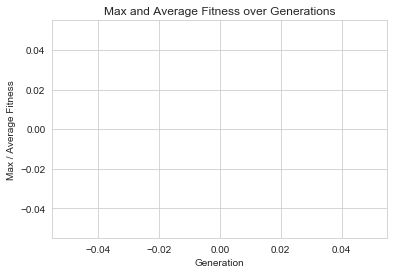

In [76]:
main()